# MNIST: Handwritten digit recognition with SuperDuperDB

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is the classic hello-world for machine learning and AI.

In this tutorial we implement MNIST classification using the paradigmatic "LeNet" based on the un-preprocessed images.

First we import the SuperDuperDB client, and create a fresh collection.

In [1]:
from superduperdb.mongodb.client import SuperDuperClient

import io
import numpy
import PIL.Image
import PIL.JpegImagePlugin
import PIL.PngImagePlugin
import torch
from torchvision import transforms
import torchvision

the_client = SuperDuperClient()
docs = the_client.mnist.digits

The data is available as `PIL.Image` images with labels in the `torchvision` package:

In [3]:
import random

mnist_data = list(torchvision.datasets.MNIST(root='./data', download=True))
random.shuffle(mnist_data)

SuperDuperDB is based on MongoDB, which does not support images and tensors and other special data types out of the box. In order to remedy this, we create custom SuperDuperDB **types**.
These types handle:
    
- How to store images as bytes in SuperDuperDB and how to reinstantiate the images from the bytes
- How to store tensors in SuperDuperDB and how to retrieve these from the database again

We do this by creating the classes in python with `.encode` and `.decode` methods:

In [4]:
class Image:
    types = (PIL.JpegImagePlugin.JpegImageFile, PIL.Image.Image,
             PIL.PngImagePlugin.PngImageFile)

    @staticmethod
    def encode(x):
        buffer = io.BytesIO()
        x.save(buffer, format='png')
        return buffer.getvalue()

    @staticmethod
    def decode(bytes_):
        return PIL.Image.open(io.BytesIO(bytes_))


class FloatTensor:
    types = (torch.FloatTensor, torch.Tensor)

    @staticmethod
    def encode(x):
        x = x.numpy()
        assert x.dtype == numpy.float32
        return memoryview(x).tobytes()

    @staticmethod
    def decode(bytes_):
        array = numpy.frombuffer(bytes_, dtype=numpy.float32)
        return torch.from_numpy(array).type(torch.float)

Once these classes are ready, we can add instances of these to SuperDuperDB, giving each type a suitable name:

In [5]:
docs.create_type('image', Image(), serializer='dill')
docs.create_type('float_tensor', FloatTensor(), serializer='dill')

Now we have these custom types, we can insert the data into SuperDuperDB:

In [6]:
_, jobs = docs.insert_many([{'img': x[0], 'class': x[1]} for x in mnist_data[:-1000]])

When data is inserted into SuperDuperDB, certain actions/ jobs are triggered. These include downloading content into the database from provided URIs, and running model **watchers** over the added data, if these have been added.

The second output from the `insert_many` statement give a dictionary of ids of the asynchronous jobs which were created.
These can also be seen in the job list:

In [7]:
docs.database.list_jobs()

[{'identifier': 'c58b349f-54d5-4d43-b7d5-2c57985af6df',
  'time': datetime.datetime(2023, 4, 3, 12, 38, 39, 293000),
  'status': 'pending',
  'method': '_download_content'}]

In this case, only one job was created - to download content. We can watch the stdout/stderr of this job like this:

In [11]:
docs.watch_job(jobs['_download_content'][0])

found 0 urls


You can see that all data apart from the final 1000 have been added:

In [9]:
docs.count_documents({})

59000

You'll see that when we fetch data from the database, it's in exactly the form that we want. For example, the images have been saved and recalled as `PIL.Image` types.

In [10]:
docs.find_one()['img']

Now that we've added the data to SuperDuperDB, we're ready to create a model. This is a simple PyTorch model implementing the iconic [LeNet architecture](https://en.wikipedia.org/wiki/LeNet). In addition to the standard PyTorch `.forward` method, SuperDuperDB allows users to specify `.preprocess` and `.postprocess` methods which define respectively:

- how the data is converted from the in-database form, to tensor
- from the output form back into the form to be stored in the database

In [12]:
def label(x):
    return torch.tensor(x)


class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(400, 120)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(120, 84)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, num_classes)

    def preprocess(self, x):
        return transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
        )(x)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    def postprocess(self, x):
        return int(x.topk(1)[1].item())

Let's test this model on a single image. `Collection.apply_model` applies the `preprocess`, `forward` and `postprocess` methods serially, creating a singleton batch prior to the `forward` and unpacking the batch after the `forward`. A similar logic is applied in all functionality which involves applying a model to the data. 

In [13]:
docs.apply_model(LeNet5(10), docs.find()[23]['img'])

0

Now that we have our model we need a target for learning - for this we use `label`:

In [14]:
docs.create_model('lenet', LeNet5(10), serializer='dill')
docs.create_function('label', label, serializer='dill')

Finally we need a loss function - this is a vanilla `torch` function, so we don't need to write extra code:

In [15]:
docs.create_objective('classification', torch.nn.CrossEntropyLoss(), serializer='dill')

And a metric to measure performance. Defined metrics are applied serially over individual data points, and the results are averaged:

In [16]:
def accuracy(x, y):
    return x == y

docs.create_metric('accuracy', accuracy, serializer='dill')

When measuring performance, SuperDuperDB requires users to create a separate validation set, which is saved for posterity and reproducibility reasons - edits and deletes on the main collection don't affect this validation set.

In [17]:
docs.create_validation_set('classification', sample_size=250)

250it [00:00, 13155.22it/s]


Now we're ready to create the model using the `Collection.create_imputation`. This trains a model to predict one part of the data using another part, specified respectively by `model_key` and `target_key`; these are subkeys of the collection documents.

In [18]:
jobs = docs.create_imputation(
    'predictor',
    'lenet',  # encoding model
    'img',    # key which we apply encoding model to
    'label',  # target model
    'class',  # key which we apply target model to
    objective='classification',
    metrics=['accuracy'],
    trainer_kwargs={'n_iterations': 1000, 'validation_interval': 50},
    validation_sets=('classification',)
)

This command creates two jobs, one to train the model, and another to apply the model to the data after training. As before, the jobs are spawned asynchronously. We can watch the output of the jobs, but in the meantime we can also do other things in our environment, and with the database. Stopping the `watch_job` command, simply breaks the connection to the logs (doesn't stop the job).

In [19]:
docs.watch_job(jobs[0])

fold: VALID; iteration: 0; epoch: 0; classification/accuracy: 0.096; objective: 2.3062571843465167; 
fold: TRAIN; iteration: 0; epoch: 0; objective: 2.3081090450286865; 
fold: TRAIN; iteration: 1; epoch: 0; objective: 2.3022372722625732; 
fold: TRAIN; iteration: 2; epoch: 0; objective: 2.286705732345581; 
fold: TRAIN; iteration: 3; epoch: 0; objective: 2.2725465297698975; 
fold: TRAIN; iteration: 4; epoch: 0; objective: 2.2787575721740723; 
fold: TRAIN; iteration: 5; epoch: 0; objective: 2.2775518894195557; 
fold: TRAIN; iteration: 6; epoch: 0; objective: 2.258601665496826; 
fold: TRAIN; iteration: 7; epoch: 0; objective: 2.2561283111572266; 
fold: TRAIN; iteration: 8; epoch: 0; objective: 2.2857656478881836; 
fold: TRAIN; iteration: 9; epoch: 0; objective: 2.2720184326171875; 
fold: TRAIN; iteration: 10; epoch: 0; objective: 2.2582945823669434; 
fold: TRAIN; iteration: 11; epoch: 0; objective: 2.2527074813842773; 
fold: TRAIN; iteration: 12; epoch: 0; objective: 2.2392578125; 
fold: T

We can continue watching the job, by executing the command again:

In [20]:
docs.watch_job(jobs[0])

fold: VALID; iteration: 0; epoch: 0; classification/accuracy: 0.096; objective: 2.3062571843465167; 
fold: TRAIN; iteration: 0; epoch: 0; objective: 2.3081090450286865; 
fold: TRAIN; iteration: 1; epoch: 0; objective: 2.3022372722625732; 
fold: TRAIN; iteration: 2; epoch: 0; objective: 2.286705732345581; 
fold: TRAIN; iteration: 3; epoch: 0; objective: 2.2725465297698975; 
fold: TRAIN; iteration: 4; epoch: 0; objective: 2.2787575721740723; 
fold: TRAIN; iteration: 5; epoch: 0; objective: 2.2775518894195557; 
fold: TRAIN; iteration: 6; epoch: 0; objective: 2.258601665496826; 
fold: TRAIN; iteration: 7; epoch: 0; objective: 2.2561283111572266; 
fold: TRAIN; iteration: 8; epoch: 0; objective: 2.2857656478881836; 
fold: TRAIN; iteration: 9; epoch: 0; objective: 2.2720184326171875; 
fold: TRAIN; iteration: 10; epoch: 0; objective: 2.2582945823669434; 
fold: TRAIN; iteration: 11; epoch: 0; objective: 2.2527074813842773; 
fold: TRAIN; iteration: 12; epoch: 0; objective: 2.2392578125; 
fold: T

fold: TRAIN; iteration: 113; epoch: 0; objective: 1.4243282079696655; 
fold: TRAIN; iteration: 114; epoch: 0; objective: 1.2730684280395508; 
fold: TRAIN; iteration: 115; epoch: 0; objective: 1.3489559888839722; 
fold: TRAIN; iteration: 116; epoch: 0; objective: 1.1814117431640625; 
fold: TRAIN; iteration: 117; epoch: 0; objective: 1.3357967138290405; 
fold: TRAIN; iteration: 118; epoch: 0; objective: 1.2825517654418945; 
fold: TRAIN; iteration: 119; epoch: 0; objective: 1.3534013032913208; 
fold: TRAIN; iteration: 120; epoch: 0; objective: 1.2315753698349; 
fold: TRAIN; iteration: 121; epoch: 0; objective: 1.183465838432312; 
fold: TRAIN; iteration: 122; epoch: 0; objective: 1.2979278564453125; 
fold: TRAIN; iteration: 123; epoch: 0; objective: 1.1404298543930054; 
fold: TRAIN; iteration: 124; epoch: 0; objective: 1.2049496173858643; 
fold: TRAIN; iteration: 125; epoch: 0; objective: 1.1770222187042236; 
fold: TRAIN; iteration: 126; epoch: 0; objective: 1.127610445022583; 
fold: TRAIN

fold: TRAIN; iteration: 225; epoch: 0; objective: 0.5535433292388916; 
fold: TRAIN; iteration: 226; epoch: 0; objective: 0.5155364871025085; 
fold: TRAIN; iteration: 227; epoch: 0; objective: 0.3822382986545563; 
fold: TRAIN; iteration: 228; epoch: 0; objective: 0.5093151926994324; 
fold: TRAIN; iteration: 229; epoch: 0; objective: 0.4552822411060333; 
fold: TRAIN; iteration: 230; epoch: 0; objective: 0.45513057708740234; 
fold: TRAIN; iteration: 231; epoch: 0; objective: 0.4466818869113922; 
fold: TRAIN; iteration: 232; epoch: 0; objective: 0.4828426241874695; 
fold: TRAIN; iteration: 233; epoch: 0; objective: 0.4763830900192261; 
fold: TRAIN; iteration: 234; epoch: 0; objective: 0.4937799870967865; 
fold: TRAIN; iteration: 235; epoch: 0; objective: 0.49009740352630615; 
fold: TRAIN; iteration: 236; epoch: 0; objective: 0.5070496201515198; 
fold: TRAIN; iteration: 237; epoch: 0; objective: 0.5286771059036255; 
fold: TRAIN; iteration: 238; epoch: 0; objective: 0.5148768424987793; 
fold

fold: TRAIN; iteration: 339; epoch: 0; objective: 0.3074381947517395; 
fold: TRAIN; iteration: 340; epoch: 0; objective: 0.3056694269180298; 
fold: TRAIN; iteration: 341; epoch: 0; objective: 0.2689163386821747; 
fold: TRAIN; iteration: 342; epoch: 0; objective: 0.4783170819282532; 
fold: TRAIN; iteration: 343; epoch: 0; objective: 0.2096068561077118; 
fold: TRAIN; iteration: 344; epoch: 0; objective: 0.30004701018333435; 
fold: TRAIN; iteration: 345; epoch: 0; objective: 0.34730494022369385; 
fold: TRAIN; iteration: 346; epoch: 0; objective: 0.24603012204170227; 
fold: TRAIN; iteration: 347; epoch: 0; objective: 0.23784461617469788; 
fold: TRAIN; iteration: 348; epoch: 0; objective: 0.43941783905029297; 
fold: TRAIN; iteration: 349; epoch: 0; objective: 0.25239431858062744; 
validating model...
saving
fold: VALID; iteration: 350; epoch: 0; classification/accuracy: 0.924; objective: 0.2839222768942515; 
fold: TRAIN; iteration: 350; epoch: 0; objective: 0.18687936663627625; 
fold: TRAIN

saving
fold: VALID; iteration: 450; epoch: 0; classification/accuracy: 0.94; objective: 0.2202315921584765; 
fold: TRAIN; iteration: 450; epoch: 0; objective: 0.3427373468875885; 
fold: TRAIN; iteration: 451; epoch: 0; objective: 0.2933960258960724; 
fold: TRAIN; iteration: 452; epoch: 0; objective: 0.24070678651332855; 
fold: TRAIN; iteration: 453; epoch: 0; objective: 0.15879234671592712; 
fold: TRAIN; iteration: 454; epoch: 0; objective: 0.24718570709228516; 
fold: TRAIN; iteration: 455; epoch: 0; objective: 0.2556569576263428; 
fold: TRAIN; iteration: 456; epoch: 0; objective: 0.12138854712247849; 
fold: TRAIN; iteration: 457; epoch: 0; objective: 0.2650008499622345; 
fold: TRAIN; iteration: 458; epoch: 0; objective: 0.29882845282554626; 
fold: TRAIN; iteration: 459; epoch: 0; objective: 0.15554076433181763; 
fold: TRAIN; iteration: 460; epoch: 0; objective: 0.16984958946704865; 
fold: TRAIN; iteration: 461; epoch: 0; objective: 0.2106398046016693; 
fold: TRAIN; iteration: 462; epo

fold: TRAIN; iteration: 561; epoch: 1; objective: 0.12399019300937653; 
fold: TRAIN; iteration: 562; epoch: 1; objective: 0.21294039487838745; 
fold: TRAIN; iteration: 563; epoch: 1; objective: 0.15567994117736816; 
fold: TRAIN; iteration: 564; epoch: 1; objective: 0.1355845332145691; 
fold: TRAIN; iteration: 565; epoch: 1; objective: 0.19686712324619293; 
fold: TRAIN; iteration: 566; epoch: 1; objective: 0.16636371612548828; 
fold: TRAIN; iteration: 567; epoch: 1; objective: 0.2233036458492279; 
fold: TRAIN; iteration: 568; epoch: 1; objective: 0.20250879228115082; 
fold: TRAIN; iteration: 569; epoch: 1; objective: 0.12003739178180695; 
fold: TRAIN; iteration: 570; epoch: 1; objective: 0.1673162430524826; 
fold: TRAIN; iteration: 571; epoch: 1; objective: 0.19965755939483643; 
fold: TRAIN; iteration: 572; epoch: 1; objective: 0.17470651865005493; 
fold: TRAIN; iteration: 573; epoch: 1; objective: 0.19950200617313385; 
fold: TRAIN; iteration: 574; epoch: 1; objective: 0.154537305235862

fold: TRAIN; iteration: 672; epoch: 1; objective: 0.13453304767608643; 
fold: TRAIN; iteration: 673; epoch: 1; objective: 0.2706030011177063; 
fold: TRAIN; iteration: 674; epoch: 1; objective: 0.13351663947105408; 
fold: TRAIN; iteration: 675; epoch: 1; objective: 0.1459687203168869; 
fold: TRAIN; iteration: 676; epoch: 1; objective: 0.1591513752937317; 
fold: TRAIN; iteration: 677; epoch: 1; objective: 0.15807530283927917; 
fold: TRAIN; iteration: 678; epoch: 1; objective: 0.168272003531456; 
fold: TRAIN; iteration: 679; epoch: 1; objective: 0.11846507340669632; 
fold: TRAIN; iteration: 680; epoch: 1; objective: 0.11052240431308746; 
fold: TRAIN; iteration: 681; epoch: 1; objective: 0.1169259324669838; 
fold: TRAIN; iteration: 682; epoch: 1; objective: 0.3086187541484833; 
fold: TRAIN; iteration: 683; epoch: 1; objective: 0.10857883095741272; 
fold: TRAIN; iteration: 684; epoch: 1; objective: 0.09190763533115387; 
fold: TRAIN; iteration: 685; epoch: 1; objective: 0.17539700865745544; 

fold: TRAIN; iteration: 785; epoch: 1; objective: 0.18785052001476288; 
fold: TRAIN; iteration: 786; epoch: 1; objective: 0.09952273219823837; 
fold: TRAIN; iteration: 787; epoch: 1; objective: 0.18721473217010498; 
fold: TRAIN; iteration: 788; epoch: 1; objective: 0.1736941933631897; 
fold: TRAIN; iteration: 789; epoch: 1; objective: 0.10788406431674957; 
fold: TRAIN; iteration: 790; epoch: 1; objective: 0.17834147810935974; 
fold: TRAIN; iteration: 791; epoch: 1; objective: 0.12719005346298218; 
fold: TRAIN; iteration: 792; epoch: 1; objective: 0.12264537811279297; 
fold: TRAIN; iteration: 793; epoch: 1; objective: 0.15268954634666443; 
fold: TRAIN; iteration: 794; epoch: 1; objective: 0.0985567644238472; 
fold: TRAIN; iteration: 795; epoch: 1; objective: 0.16299723088741302; 
fold: TRAIN; iteration: 796; epoch: 1; objective: 0.12490257620811462; 
fold: TRAIN; iteration: 797; epoch: 1; objective: 0.07185285538434982; 
fold: TRAIN; iteration: 798; epoch: 1; objective: 0.13081333041191

fold: TRAIN; iteration: 896; epoch: 1; objective: 0.143004909157753; 
fold: TRAIN; iteration: 897; epoch: 1; objective: 0.17877762019634247; 
fold: TRAIN; iteration: 898; epoch: 1; objective: 0.19388040900230408; 
fold: TRAIN; iteration: 899; epoch: 1; objective: 0.057186201214790344; 
validating model...
saving
fold: VALID; iteration: 900; epoch: 1; classification/accuracy: 0.972; objective: 0.12656324803829194; 
fold: TRAIN; iteration: 900; epoch: 1; objective: 0.10010326653718948; 
fold: TRAIN; iteration: 901; epoch: 1; objective: 0.18034546077251434; 
fold: TRAIN; iteration: 902; epoch: 1; objective: 0.10843949019908905; 
fold: TRAIN; iteration: 903; epoch: 1; objective: 0.15338784456253052; 
fold: TRAIN; iteration: 904; epoch: 1; objective: 0.1375640332698822; 
fold: TRAIN; iteration: 905; epoch: 1; objective: 0.12990571558475494; 
fold: TRAIN; iteration: 906; epoch: 1; objective: 0.17104536294937134; 
fold: TRAIN; iteration: 907; epoch: 1; objective: 0.24392536282539368; 
fold: T

Now the training has finished, we can watch the computation of model outputs:

In [21]:
docs.watch_job(jobs[1])

computing chunk (1/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (2/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (3/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (4/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (5/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (6/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (7/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (8/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (9/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (10/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (11/12)
finding documents under filter
done.
bulk writing...
done.
computing chunk (12/12)
finding documents under filter
done.
bulk writing...
done.


In [22]:
info = docs.database.get_object_info('predictor', 'learning_task')
info

{'_id': ObjectId('642aacc1e9dde2a6de1976af'),
 'variety': 'learning_task',
 'identifier': 'predictor',
 'query_params': ['digits', {}],
 'models': ['lenet', 'label'],
 'keys': ['img', 'class'],
 'metrics': ['accuracy'],
 'objective': 'classification',
 'splitter': None,
 'validation_sets': ['classification'],
 'keys_to_watch': ['img'],
 'trainer_kwargs': {'n_iterations': 1000,
  'validation_interval': 50,
  'loader_suppress': ['_id']},
 'trainer': 'ImputationTrainer',
 'task_type': 'imputation',
 'metric_values': {'classification': {'accuracy': [0.096,
    0.48,
    0.728,
    0.844,
    0.864,
    0.896,
    0.908,
    0.924,
    0.944,
    0.94,
    0.952,
    0.952,
    0.952,
    0.956,
    0.96,
    0.96,
    0.968,
    0.964,
    0.972,
    0.964,
    0.972]},
  'objective': [2.3062571843465167,
   2.0219791690508524,
   1.470482877890269,
   0.9092001179854076,
   0.5880270600318909,
   0.42862788736820223,
   0.33637697498003644,
   0.2839222768942515,
   0.250561593969663,
   

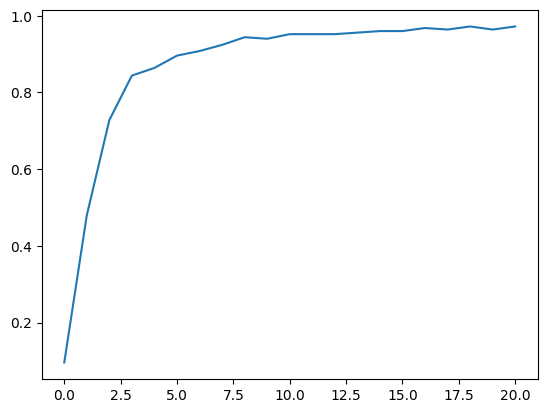

In [23]:
from matplotlib import pyplot as plt

plt.plot(info['metric_values']['classification']['accuracy'])

Accuracy is good, and we can see the outputs have been added to the documents (`_outputs.img.lenet`):

In [24]:
docs.find_one()

{'_id': ObjectId('642aacade9dde2a6de189027'),
 'img': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'class': 1,
 '_fold': 'train',
 '_outputs': {'img': {'lenet': 1}}}

After training, you'll see that a model **watcher** has been created, which keeps the `img` key up-to-date

In [25]:
docs.list_watchers()

['predictor/img']

When new data are added, the trained model kicks into action 
and it's outputs are added/ enriched to the newly added data

In [26]:
_, jobs = docs.insert_many([{'img': x[0], 'class': x[1], 'update': True} for x in mnist_data[-1000:]])

We can watch the progress of adding this new data as before:

In [ ]:
docs.watch_job(jobs['watcher', 'predictor'][0])

After inserting and training the model, the model is automatically served on the SuperDuperDB model-server. If you're deployment is exposed to the internet, then these predictions are available anywhere:

In [ ]:
im = docs.find_one({'_fold': 'valid'})['img']
im

In [ ]:
docs.apply_model('lenet', im)